# PI control
In this tutorial we'll introduce
1. PI control, a commonly used model-free control method,
2. the concept of decomposing the `IOProcessor`'s computation into `ProcessingBlock`s, and
3. modeling computation delays on those blocks to reflect hardware and algorithmic speed limitations present in a real experiment.

Preamble:

In [1]:
from brian2 import *
import matplotlib.pyplot as plt
from cleosim import *

utilities.style_plots_for_docs()

np.random.seed(7000)

# the default cython compilation target isn't worth it for 
# this trivial example
prefs.codegen.target = "numpy"

INFO       Cache size for target 'cython': 1933664869 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the '/home/kyle/.cython/brian_extensions' directory. [brian2]


## Create the Brian network
We'll create a population of 10 LIF neurons mainly driven by feedforward input but with some recurrent connections as well.

In [2]:
n = 10
population = NeuronGroup(n, '''
            dv/dt = (-v - 70*mV + Rm*I) / tau : volt
            tau: second
            Rm: ohm
            I: amp''',
        threshold='v>-50*mV',
        reset='v=-70*mV'
)
population.tau = 10*ms
population.Rm = 100*Mohm
population.I = 0*mA
population.v = -70*mV

input_group = PoissonGroup(n, np.linspace(20, 200, n)*Hz)

S = Synapses(input_group, population, on_pre='v+=5*mV')
S.connect(condition=f'abs(i-j)<={3}')
S2 = Synapses(population, population, on_pre='v+=2*mV')
S2.connect(p=0.2)

pop_mon = SpikeMonitor(population)

net = Network(population, input_group, S, S2, pop_mon)
population.equations

dv/dt = (I*Rm - 70*mV - v)/tau : volt
I : amp
Rm : ohm
tau : second


## Run simulation without control:

In [3]:
net.run(100*ms)

INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.08s). [brian2.stateupdaters.base.method_choice]


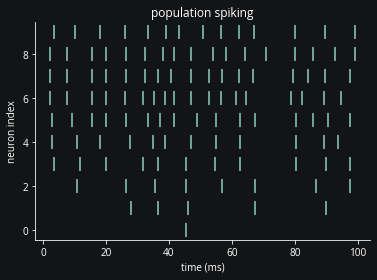

In [4]:
fig, ax = plt.subplots()
ax.scatter(pop_mon.t / ms, pop_mon.i, marker='|', s=200); 
ax.set(title='population spiking', ylabel='neuron index', xlabel='time (ms)');

## Constructing a closed-loop simulation

We will use the popular model-free PI control to control a single neuron's firing rate. PI stands for proportional-integral, referring to a feedback gain *proportional* to the instantaneous error as well as the *integrated* error over time.

First we construct a `CLSimulator` from the network:

In [5]:
from cleosim import CLSimulator
sim = CLSimulator(net)

Then, to control neuron $i$, we need to:
1. capture spiking using a `GroundTruthSpikeRecorder`

In [6]:
from cleosim.recorders import GroundTruthSpikeRecorder
i = 0  # neuron to control
rec = GroundTruthSpikeRecorder('spike_rec')
sim.inject_recorder(rec, population[i])

2. define the firing rate trajectory we want our target neuron to follow

In [7]:
# the target firing rate trajectory, as a function of time
def target_Hz(t_ms):
    if t_ms < 250:  # constant target at first
        return 400
    else:  # sinusoidal afterwards
        a = 200
        t_s = t_ms / 1000
        return a + a * np.sin(2 * np.pi * 20 * t_s)

2. estimating its firing rate from incoming spikes using a `FiringRateEstimator`
3. compute the stimulus intensity with a `PIController`
4. output that value for a `StateVariableSetter` stimulator to use

Here we initialize blocks when the `IOProcessor` is created and define how to process network output and set the control signal in the `process` function.

In [8]:
from cleosim.processing import (
    LatencyIOProcessor,
    FiringRateEstimator,
    ConstantDelay,
    PIController,
)

class PIRateIOProcessor(LatencyIOProcessor):
    delta = 1  # ms

    def __init__(self):
        super().__init__(sample_period_ms=self.delta, processing="parallel")
        self.rate_estimator = FiringRateEstimator(
            tau_ms=15,
            sample_period_ms=self.delta,
            delay=ConstantDelay(4.1),  # latency in ms
            save_history=True,  # lets us plot later
        )

        # using hand-tuned gains that seem reasonable
        self.pi_controller = PIController(
            target_Hz,
            Kp=0.005,
            Ki=0.04,
            sample_period_ms=self.delta,
            delay=ConstantDelay(2.87),  # latency in ms
            save_history=True,  # lets us plot later
        )

    def process(self, state_dict, sample_time_ms):
        spikes = state_dict["spike_rec"]
        # feed output and out_time through each block
        out, time_ms = self.rate_estimator.process(
            spikes, sample_time_ms, sample_time_ms=sample_time_ms
        )
        out, time_ms = self.pi_controller.process(
            out, time_ms, sample_time_ms=sample_time_ms
        )
        # this dictionary output format allows for the flexibility
        # of controlling multiple stimulators
        if out < 0:  # limit to positive current
            out = 0
        out_dict = {"I_stim": out}
        # time_ms at the end reflects the delays added by each block
        return out_dict, time_ms

io_processor = PIRateIOProcessor()
sim.set_io_processor(io_processor)

Note that we can set delays for individual `ProcessingBlock`s in the IO processor to better
approximate the experiment. We use simple constant delays here, but a `GaussianDelay` class
is also available and others could be easily implemented.

Now we inject the stimulator:

In [9]:
from cleosim.stimulators import StateVariableSetter
sim.inject_stimulator(
        StateVariableSetter(
            'I_stim', variable_to_ctrl='I', unit=nA),
        population[i]
)

## Run the simulation

In [10]:
sim.run(300*ms)

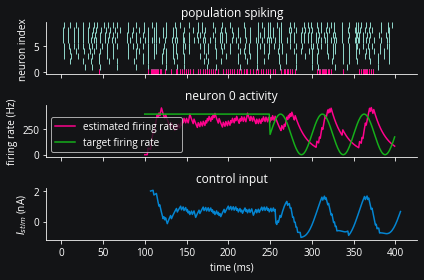

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True);
ax1.plot(pop_mon.t / ms, pop_mon.i[:], '|');
ax1.plot(pop_mon.t[pop_mon.i == i]/ms, pop_mon.i[pop_mon.i==i], '|', c='xkcd:hot pink') 
ax1.set(title='population spiking', ylabel='neuron index')

ax2.plot(io_processor.rate_estimator.t_in_ms, io_processor.rate_estimator.values, c='xkcd:hot pink');
ax2.plot(io_processor.rate_estimator.t_in_ms, [target_Hz(t) for t in io_processor.rate_estimator.t_in_ms],\
         c='xkcd:green');
ax2.set(ylabel='firing rate (Hz)', title=f'neuron {i} activity');
ax2.legend(['estimated firing rate', 'target firing rate']);

ax3.plot(io_processor.pi_controller.t_out_ms, io_processor.pi_controller.values, c='xkcd:cerulean')
ax3.set(title='control input', ylabel='$I_{stim}$ (nA)', xlabel='time (ms)')

fig.tight_layout()
fig.show()

_Note the lag in keeping up with the target firing rate, which can
be directly attributed to the ~7 ms delay we coded in to the IO processor._

## Conclusion
In this tutorial, we've learned how to
* use PI control to interact with a Brian simulation,
* decompose processing steps into blocks, and
* assign delays to processing blocks to model real-life latency. 